In [4]:
from pypinyin import lazy_pinyin
import editdistance
import warnings
import seaborn as sns
# from data_utils import *
from pylab import *  # 支持中文
import matplotlib.pyplot as plt

cmap = sns.cubehelix_palette(
    start=0.17, gamma=0.5, light=.9, as_cmap=True)

In [93]:
# test_file_path = '../exp/data/cn/cctc/cctc_test.dcn.txt'
# test_file_path = '../exp/data/cn/findoc/findoc_test.dcn.txt'
test_file_path = '../exp/data/cn/sighan15/sighan15_test.dcn.txt'

rec = {}
for line in open(test_file_path, 'r'):
    err, cor, _, _ = line.strip().split('\t')
    err, cor = err.strip().split(' '), cor.strip().split(' ')
    err_py, cor_py = lazy_pinyin(err), lazy_pinyin(cor)
    for e, c, ep, cp in zip(err, cor, err_py, cor_py):
        if e != c:
            rec.setdefault(cp, [])
            rec[cp].append(ep)
len(rec)

182

In [94]:
ed = []
for cp in rec.keys():
    for ep in rec[cp]:
        score = editdistance.distance(cp, ep)
        ed.append(score)
        # if score > 1:
            # print(cp, ep)

Counter(ed)

Counter({1: 172, 0: 467, 3: 13, 2: 42, 5: 9, 4: 1, 6: 1})

In [18]:
import json
ime = json.load(open('../data/input_candidates.google.json', 'r'))

In [95]:
from tqdm import tqdm
test_file_path_case = {
    "sighan15": '../exp/data/cn/sighan15/sighan15_test.dcn.txt',
    "cctc": '../exp/data/cn/cctc/cctc_test.dcn.txt',
    'findoc': '../exp/data/cn/findoc/findoc_test.dcn.txt',
    'W271k': '../exp/data/cn/Wang271k/dcn_train.dcn.txt'
}

rec = {}
for name, test_file_path in test_file_path_case.items():
    _rec = []
    for line in tqdm(open(test_file_path, 'r')):
        err, cor = line.strip().split('\t')[:2]
        err, cor = err.strip().split(' '), cor.strip().split(' ')
        err_py, cor_py = lazy_pinyin(err), lazy_pinyin(cor)
        for e, c, ep, cp in zip(err, cor, err_py, cor_py):
            if e != c:
                _rec.append((e, c, ep, cp))
    rec[name] = _rec

In [98]:
def get_order(_rec):
    order = []
    for e, c, ep, cp in _rec:
        try:
            order.append(ime[cp].index(e))
        except:
            order.append(-1)
    return [v for v in order]

sighan15_order = get_order(rec['sighan15'])
findoc_order = get_order(rec['findoc'])
cctc_order = get_order(rec['cctc'])
w271k_order = get_order(rec['W271k'])

In [100]:
from collections import Counter
ignore_zero = [i for i in range(-1, 20)]
sighan15_order = sorted(Counter(sighan15_order + ignore_zero).items())
findoc_order = sorted(Counter(findoc_order + ignore_zero).items())
cctc_order = sorted(Counter(cctc_order + ignore_zero).items())
w271k_order = sorted(Counter(w271k_order + ignore_zero).items())

In [101]:
def first_line_rate(order):
    first_line_count = sum([x[1] for x in order if 0 <= x[0] < 8 ])
    all_count = sum(x[1] for x in order)
    return first_line_count / all_count

print(
    first_line_rate(sighan15_order),
    first_line_rate(findoc_order),
    first_line_rate(cctc_order),
    first_line_rate(w271k_order)
)

0.6143250688705234 0.5185185185185185 0.4955640050697085 0.26550740731393385


/home/chendian/.conda/envs/pycorrector/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  This is separate from the ipykernel package so we can avoid doing imports until


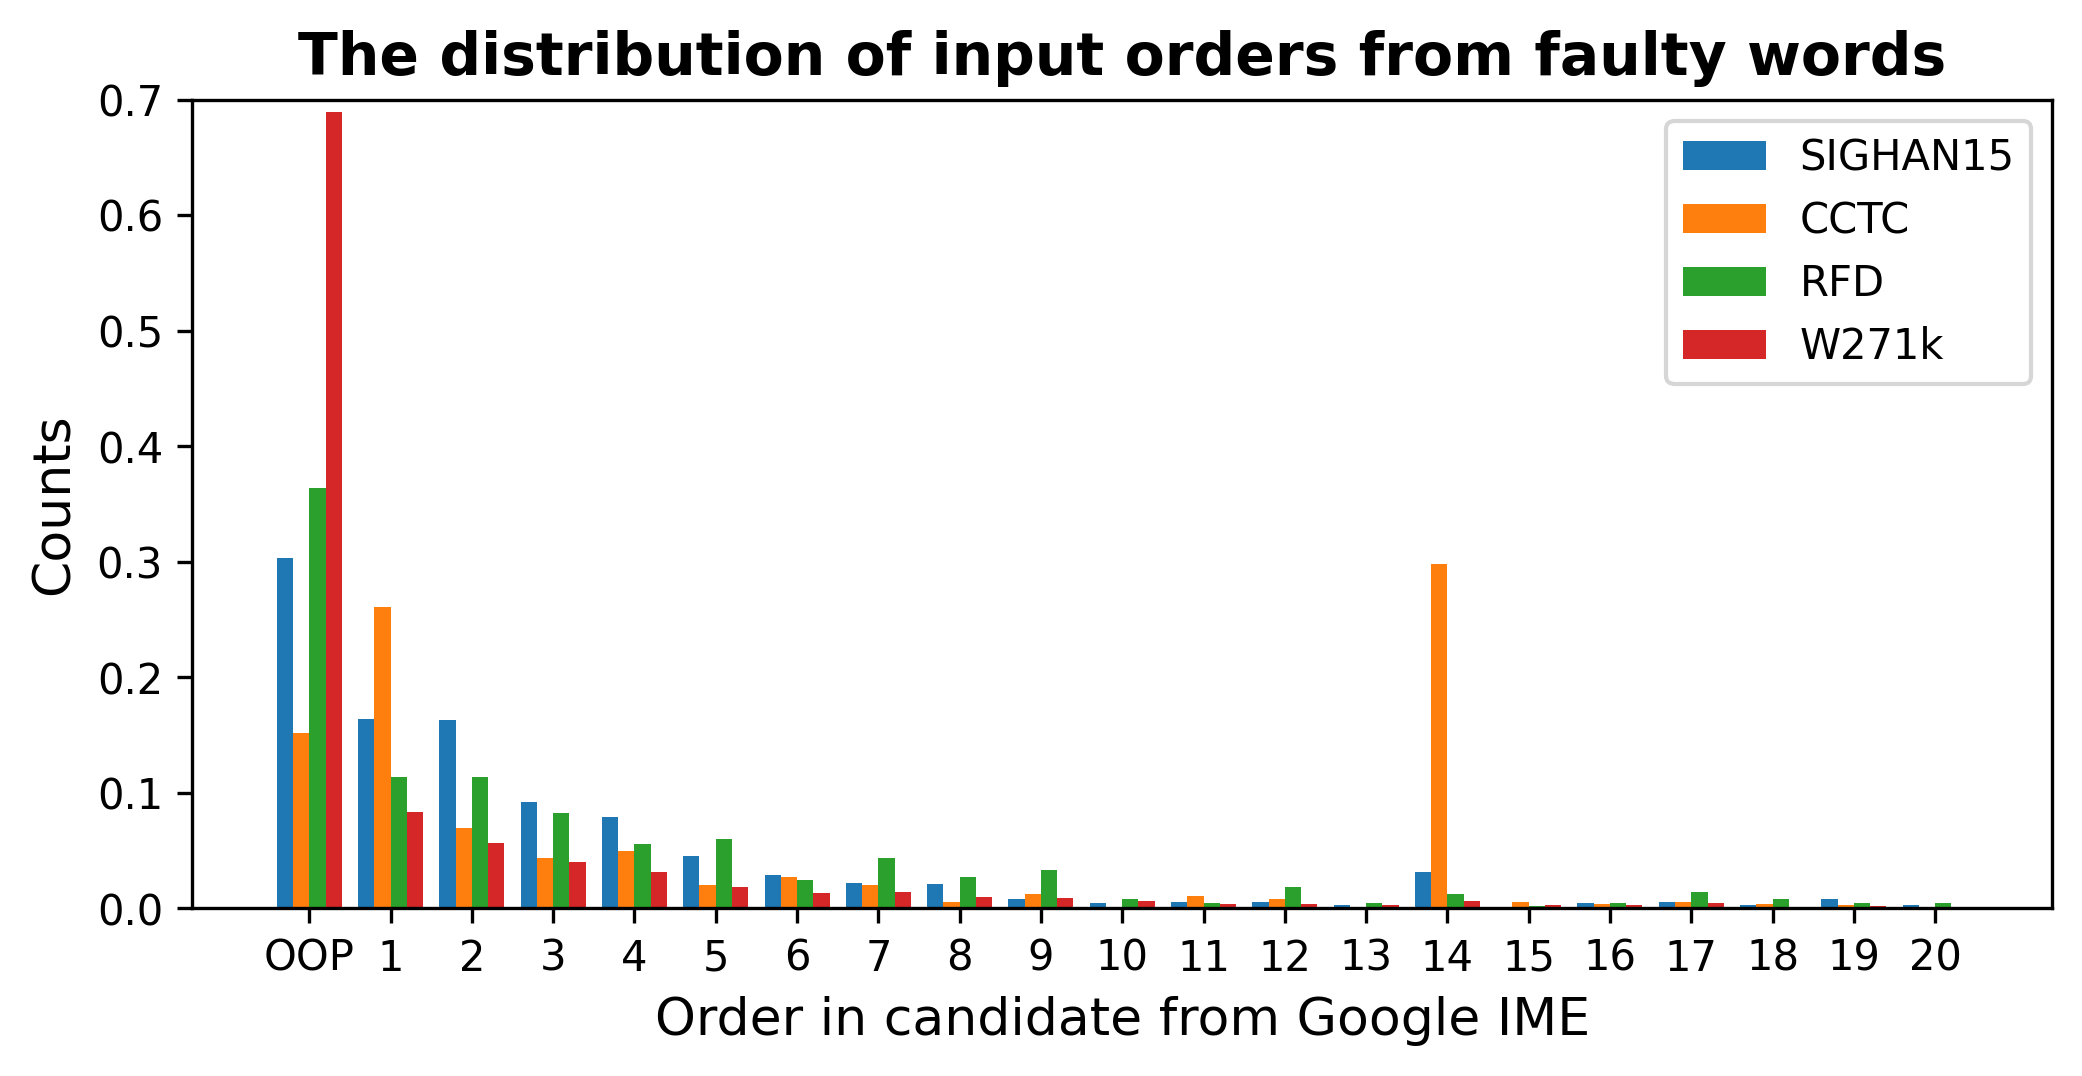

In [106]:
import numpy as np
size = 21

## 两组数据
count_sighan15 = [x[1] for x in sighan15_order]
count_cctc = [x[1] for x in cctc_order]
count_findoc = [x[1] for x in findoc_order]
count_w271k = [x[1] for x in w271k_order]

rate_sighan15 = [x / sum([o[1] for o in sighan15_order]) for x in count_sighan15]
rate_cctc = [x / sum([o[1] for o in cctc_order]) for x in count_cctc]
rate_findoc = [x / sum([o[1] for o in findoc_order]) for x in count_findoc]
rate_w271k = [x / sum([o[1] for o in w271k_order]) for x in count_w271k]

x = np.arange(size)

# 有a/b两种类型的数据，n设置为2
total_width, n = 0.8, 4

# 每种类型的柱状图宽度
width = total_width / n
plt.figure(figsize=(8, 3.5), dpi=300)
plt.figure(1)
plt.bar(x - 1.5 * width, rate_sighan15, width=width, label="SIGHAN15")
plt.bar(x - 0.5 * width, rate_cctc, width=width, label="CCTC")
plt.bar(x + 0.5 * width, rate_findoc, width=width, label="RFD")
plt.bar(x + 1.5 * width, rate_w271k, width=width, label="W271k")  # E27969

## x轴刻度名称
xticks = ['OOP'] + [str(i) for i in range(1, size)]
xline = [i for i in np.arange(size)]
plt.xticks(xline, xticks)

plt.legend(loc='upper right')
plt.ylim(0, 0.7)
plt.xlabel("Order in candidate from Google IME", fontdict={'size': 12.5})
plt.ylabel("Counts", fontdict={'size': 12.5})
plt.title('The distribution of input orders from faulty words', fontdict={'weight': 'bold', 'size': 14})

# 显示柱状图
plt.show()